# Learning Kinetics from Time Series Data

This notebook is an implementation of Kinetic Learning.

## TODO for Publication

### Code Functionality:
1. Develop a Data Set to simulate the method for testing.
    * [ ] Trouble Shoot Data Generation Function to figure out why Integration is failing...
2. [X] Implement Kinetic Model Prediction + Plot Prediction on Experimental Prediction Plots
3. [ ] Add RMSE Metrics For Kinetic Model and report

### Code Quality:
1. [X] Rewrite and Simplify Code.
2. [ ] Add to Version control.

### Paper Writing:

1. [ ] Normalize Axes On Big Simulated Data Plot
2. [ ] Create Advantages Figure Which Compares Kinetic Modeling to Machine Learning of Dynamics

3. Update Figures for Each Simulation to Mirror Most Up to Date Version
    * [X] Improve Simulated Figures (Add Legend + Make Target more noticable)
    * [X] Simulated / Simple
    * [X] Simulated / Limonene
    * [X] Experimental / Limonene
    * [X] Experimental / Isopentenol
6. [X] Incorporate Kinetic Model Comparisons into Existing Experimental data set plots (if they are even at all close)

## Ideas for Future:
1. Implement Code in tensor flow (with a better machine learning model...)
2. Expand number of pathway models -- show i can learn simulated data for many pathways
3. Optimize titer using this method directly inferred from data!

# 1. Set Flags For Running Code
Four data sets are supported in this code.  Two are simulated, and two are from experimental data. Change the set_num variable below to choose which data set to fit.

In [1]:
#Choose the data set to run
data_sets = [('simulated','small'),          #Small Canonical Pathway Model with Feedback Inhibition 
             ('simulated','limonene'),        #Large Limonene Model Developed Based on the Literature
             ('experimental','isopentenol'),  #Experimental Isopentenol Pathway Time Series Data
             ('experimental','limonene')]     #Experimental Limonene Pathway Time Series Data

set_num = 1

The Machine Learning Model is determined by these flags.  The features to use can be automatic or manual and the machine learning model can be chosen. Additionally, the random seed can be set.

In [2]:
feature_selection = 'Automatic'   #Manual or Automatic: Manual has hand selected features, Autmatic uses an algorithm
machine_learning_model = 'tpot'   #neural,random_forest(RF)

#Set Random Seed for deterministic Execution
seed = None #If seed is set then output will be deterministic (And results can be cached for faster execution)

#Time Consuming, will be cached for each unique case. (Only Relevant for experimental Limonene Pathway)
run_kinetic_model = True #Allows for comparison between ml model and kinetic model performance

Variables to Set For Simulated Data Sets (How Many Strains and how many training sets needed

In [3]:
#Relevant if Simulated
data_type,pathway = data_sets[set_num]
if data_sets[set_num][0] == 'simulated':
    strain_numbers = [10,40,160]
    training_sets = 20 #Change to support a variable number here (I want to shoot for 10...)
    
    #Strains Needed Calculation
    strains_needed = (max(strain_numbers) + 1)*training_sets + 1
    print(strains_needed)
    
    #Calculation of training_size values
    train_sizes = []
    for strain_number in strain_numbers:
        train_size = (strain_number + 1) * training_sets / (strains_needed - 1)
        train_sizes.append(train_size)
    print(train_sizes)
    
    print([int((strains_needed-1)*size/training_sets)-1 for size in train_sizes])
    #Strains Required

    training_strains = strains_needed
    test_strains = 200

elif data_type == 'experimental':
    pass


#Plotting Options (If set true more extensive plots are created for troubleshooting purposes)
Plot_Data = False

911
[0.12087912087912088, 0.34065934065934067, 1.0]
[10, 30, 90]


# 2. Import Modules & Setup
Importing all required modules and helper functions

In [4]:
%matplotlib inline
from plot import *
from helper import *
from IPython.display import display
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import differential_evolution
import math
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')

# 3. Load & Format Data into DataFrame

In [5]:
if data_type == 'simulated':
    if pathway == 'limonene':
        file_name = 'data/Fulld10000n0.csv'
        y0 = [1e-5]*10
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']
        targets=['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
        specific_features = {'Acetyl-CoA':      ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR'],
                             'Acetoacetyl-CoA': ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMG-CoA'],
                             'HMG-CoA':         ['Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMGS','HMG-CoA'],
                             'Mev':             ['Acetyl-CoA','Acetoacetyl-CoA','HMGS','HMG-CoA','MK','Mev','GPP','MevP'],
                             'MevP':            ['MK','Mev','GPP','MevP','PMK'],
                             'MevPP':           ['PMK','MevP','PMD','MevPP','Mev'],
                             'IPP':             ['PMD','MevPP','MevP','Mev','Idi','IPP','GPPS','DMAPP'],
                             'DMAPP':           ['Idi','IPP','GPPS','DMAPP'],
                             'GPP':             ['GPPS','IPP','DMAPP','GPP','LS'],
                             'Limonene':        ['LS','GPP']}

        tsdf = generateTSDataSet(df,features,targets)

    elif pathway=='small':
        file_name = 'data/SmallKineticsd30000n0.csv'
        y0 = [0.2]*3
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['e0','e1']
        targets=['s0','s1','s2']
        specific_features = {'s0': ['e0','e1','s0','s1','s2'],
                             's1': ['e0','e1','s0','s1','s2'],
                             's2': ['e0','e1','s0','s1','s2']}

        tsdf = generateTSDataSet(df,features,targets)        
    
elif data_type == 'experimental':
    if pathway == 'limonene':
        #Parameters that Can Be Set:
        strains = ['L1','L2','L3']
        training_strains = ['L1','L3']
        test_strains = ['L2']

        #Define Machine Learning Targets & Features To Use

        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']
        features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','Limonene Synthase','Limonene g/L'],
                             'Limonene g/L':['OD600','ATP (uM)','Limonene Synthase','Limonene g/L','GPP (uM)']}

    elif pathway == 'isopentenol':
        #Parameters that Can Be Set:
        strains = ['I1','I2','I3']
        training_strains = ['I1','I3']
        test_strains = ['I2']
        
        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']
        features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','NudB','Isopentenol g/L'],
                             'Isopentenol g/L':['OD600','ATP (uM)','NudB','Isopentenol g/L','IPP/DMAPP (uM)']}

    
    #Processing Data Files and Creating a Shared Dataframe
    metabolite_file_name = 'data/time_series_metabolomics.csv'
    protein_file_name = 'data/time_series_proteomics.csv'

    mdf = pd.read_csv(metabolite_file_name)
    pdf = pd.read_csv(protein_file_name)

    #Format protein tables
    proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB']
    proteins = [('ProteinArea',protein) for protein in proteins]
    columns = ['Strain','Time','Protein','ProteinArea']

    pdf = pdf.loc[pdf['Strain'].isin(strains)]
    pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
    pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)

    pdf.rename(columns={'Hour': 'Time'}, inplace=True)    
    pdf = pdf[columns].pivot_table(pdf,index=['Strain','Time'],columns='Protein',aggfunc=np.sum)
    pdf = pdf[proteins]
    pdf.columns = pdf.columns.get_level_values(1)
    
    #Format metabolite tables
    metabolites = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

    mdf = mdf.loc[mdf['Strain'].isin(strains)]
    
    mdf.rename(columns={'Hour': 'Time'}, inplace=True)
    mdf = mdf[['Strain','Time'] + metabolites].pivot_table(mdf,index=['Strain','Time'],aggfunc=np.sum)
    
    #Extracellular Metabolites (mg/L) | Intracelluar Metabolites (mg/L) |Combined Metabolites (mg/L)

    #Join metabolite and protein tables
    df = pd.concat([pdf, mdf], axis=1)
    test_df = df.loc[(test_strains,slice(None))]
    display(test_df)
    df = df.loc[(training_strains,slice(None))]
    tsdf = generateTSDataSet(df,features,targets)

Total Time Series in Data Set:  911


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
display(df)

Acetoacetyl-CoA  Acetyl-CoA          AtoB     DMAPP       GPP  \
Strain Time                                                                  
7      0            0.200000    0.200000  4.208035e+00  0.200000  0.200000   
       1            0.202479    0.203936  4.442228e+06  0.200332  0.200139   
       2            0.207258    0.205115  5.801599e+06  0.201061  0.200298   
       3            0.212946    0.205235  6.460604e+06  0.201964  0.200455   
       4            0.219109    0.204800  6.849630e+06  0.202971  0.200613   
       5            0.225552    0.204034  7.106377e+06  0.204050  0.200775   
       6            0.232170    0.203055  7.288508e+06  0.205186  0.200942   
       7            0.238901    0.201935  7.424425e+06  0.206369  0.201114   
       8            0.245703    0.200721  7.529736e+06  0.207593  0.201292   
       9            0.252549    0.199443  7.613733e+06  0.208853  0.201477   
       10           0.259420    0.198124  7.682292e+06  0.210145  0.201668   
       11           0.266301    0.196781  7.739311e+06  0.211468  0.201865   
       12           0.273183    0.195426  7.787477e+06  0.212818  0.202070   
       13           0.280057    0.194069  7.828704e+06  0.214195  0.202281   
       14           0.286918    0.192717  7.864391e+06  0.215596  0.202499   
       15           0.293761    0.191376  7.895583e+06  0.217020  0.202724   
       16           0.300583    0.190050  7.923080e+06  0.218467  0.202956   
       17           0.307380    0.188742  7.947502e+06  0.219935  0.203195   
       18           0.314152    0.187456  7.969337e+06  0.221423  0.203441   
       19           0.320896    0.186193  7.988975e+06  0.222930  0.203694   
       20           0.327612    0.184956  8.006733e+06  0.224455  0.203953   
       21           0.334298    0.183745  8.022867e+06  0.225998  0.204220   
       22           0.340955    0.182561  8.037592e+06  0.227559  0.204494   
       23           0.347582    0.181406  8.051083e+06  0.229135  0.204774   
       24           0.354179    0.180279  8.063490e+06  0.230727  0.205061   
       25           0.360746    0.179181  8.074938e+06  0.232334  0.205355   
       26           0.367284    0.178111  8.085534e+06  0.233955  0.205656   
       27           0.373792    0.177071  8.095370e+06  0.235590  0.205964   
       28           0.380271    0.176059  8.104525e+06  0.237239  0.206278   
       29           0.386721    0.175075  8.113068e+06  0.238900  0.206599   
...                      ...         ...           ...       ...       ...   
9998   40           0.243414    0.251129  3.198211e+06  0.230007  0.173260   
       41           0.244683    0.251674  3.199817e+06  0.230852  0.172776   
       42           0.245952    0.252201  3.201348e+06  0.231697  0.172301   
       43           0.247221    0.252711  3.202809e+06  0.232541  0.171833   
       44           0.248490    0.253205  3.204205e+06  0.233385  0.171372   
       45           0.249758    0.253682  3.205540e+06  0.234227  0.170919   
       46           0.251026    0.254142  3.206818e+06  0.235070  0.170473   
       47           0.252294    0.254588  3.208043e+06  0.235911  0.170033   
       48           0.253560    0.255018  3.209217e+06  0.236751  0.169601   
       49           0.254826    0.255433  3.210345e+06  0.237589  0.169176   
       50           0.256090    0.255834  3.211428e+06  0.238426  0.168757   
       51           0.257354    0.256220  3.212469e+06  0.239262  0.168344   
       52           0.258616    0.256593  3.213471e+06  0.240096  0.167938   
       53           0.259876    0.256953  3.214436e+06  0.240928  0.167538   
       54           0.261136    0.257299  3.215365e+06  0.241758  0.167144   
       55           0.262393    0.257633  3.216261e+06  0.242586  0.166756   
       56           0.263649    0.257954  3.217126e+06  0.243412  0.166374   
       57           0.264903    0.258263  3.217961e+06  0.244235  0.165998   
       58           0.266156    0.2

# 4. Construct Machine Learning Models
First Do Feature Selection if Automatic features are selected.

In [7]:
#Automatic Feature Selection using Recursive Feature Selection cross validated with a Random Forest Regressor
if feature_selection == 'automatic':
    estimator = RandomForestRegressor()
    specific_features = {}
    feature_list = [('feature',feature) for feature in features + targets]
    for target in targets:
        
        #display(tsdf[feature_list].ix[:100])
        if data_type == 'simulated':
            X = tsdf[feature_list].ix[:2000].values.tolist()
            y = tsdf[('target',target)].ix[:2000].values.tolist()        
        else:
            X = tsdf[feature_list].values.tolist()
            y = tsdf[('target',target)].values.tolist()
            
        selector = RFECV(estimator,verbose=1)
        selector.fit(X,y)
        mask = selector.get_support()
        specific_features[target] = [feature for i,feature in enumerate(features + targets) if mask[i]]
        print(target,specific_features[target])

Define all Possible Machine Learning Models that can be used in the analysis.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

#Create Models for Each Target Column
modelDict = {}

#Pipeline Regressors
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                               ('SVR',SVR())])

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=3, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=None, scoring='r2')),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
featureReducingRF = Pipeline([('Feature Reduction',SelectKBest(mutual_info_regression, k=4)),
                              ('Random Forest Regressor',RandomForestRegressor())])


model_str = machine_learning_model
featureReduction = False
if model_str == 'SVR':
    mlmodel = supportVectorRegressor
elif model_str == 'RF':
    mlmodel = RandomForestRegressor(n_estimators=20)
elif model_str == 'Poly':
    mlmodel = polynomialRegressor
elif model_str == 'Bagging':
    mlmodel = BaggingRegressor(base_estimator=supportVectorRegressor)
elif model_str == 'FeatRF':
    mlmodel = featureReducingRF 
    featureReduction = True
elif model_str == 'Log':
    LogScale = FunctionTransformer(np.log1p)
    mlmodel = Pipeline([('Log Transform',LogScale),('Scaler',StandardScaler()),
                        ('Linear',LassoLarsIC())])
elif model_str == 'neural':
    neural_model = Pipeline([('Scaler',StandardScaler()),
                               ('neural_net',MLPRegressor(hidden_layer_sizes=(5,5,5),
                                                          learning_rate_init=0.1,
                                                          learning_rate='adaptive',
                                                          solver='sgd',
                                                          activation='tanh',
                                                          max_iter=1000))])
    #mlmodel = MLPRegressor(hidden_layer_sizes=(10,10),learning_rate_init=0.1,solver='lbfgs')
    mlmodel= neural_model
    
elif model_str == 'gaussian':
    mlmodel = Pipeline([('Scaler',StandardScaler()),
                        ('gassian',GaussianProcessRegressor(normalize_y=True))])
elif model_str == 'tpot':
    from tpot import TPOTRegressor
    mlmodel = TPOTRegressor(generations=130, population_size=100, verbosity=2,max_time_mins=20,cv=ShuffleSplit(),scoring='r2',n_jobs=1)

## 5. Fitting & Evaluating Machine Learning Models

For both simulated and real data we calculate the goodness of fit of the machine learning models. For Simulated Data we calculate the following Metrics which help us evaluate goodness of fit.

Simulated Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives (Combined Vector Derivative Error RMSE)
3. Goodness of Fit Plot For Simulated Curves
4. RMSE for all simulated curves, Figure out the right one to report (Seperate and together -- Normalized / Percent / Regular)

Experimental Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives, (Combined Vector)
3. Comparison Plot between Real and Predicted Curves
4. RMSE for Single Predicted Curve, (By Metabolite and Combined)

Acetoacetyl-CoA


Optimization Progress: 176pipeline [05:02,  1.27s/pipeline]                   

Generation 1 - Current best internal CV score: 3.122687438932095e-08


Optimization Progress: 273pipeline [09:13,  2.76s/pipeline]                   

Generation 2 - Current best internal CV score: 2.8470487896083503e-08


Optimization Progress: 367pipeline [14:26,  3.24s/pipeline]                   

Generation 3 - Current best internal CV score: 2.2440446168817694e-08


Optimization Progress: 458pipeline [20:34,  2.95s/pipeline]                   

Generation 4 - Current best internal CV score: 1.9810844309558247e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.75, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=14, ExtraTreesRegressor__n_estimators=100)


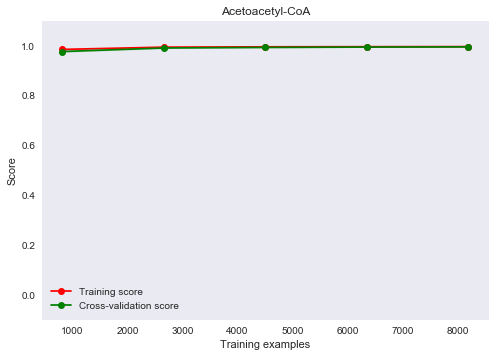

Acetyl-CoA


Optimization Progress: 183pipeline [04:08,  1.17s/pipeline]                  

Generation 1 - Current best internal CV score: 4.855138271242299e-08


Optimization Progress: 276pipeline [06:04,  1.13pipeline/s]                   

Generation 2 - Current best internal CV score: 3.863280893524899e-08


Optimization Progress: 370pipeline [12:41,  2.26s/pipeline]                   

Generation 3 - Current best internal CV score: 3.863280893524899e-08


Optimization Progress: 464pipeline [16:21,  2.53s/pipeline]                   

Generation 4 - Current best internal CV score: 3.6734776155872114e-08


Optimization Progress: 558pipeline [21:38,  2.26s/pipeline]                   

Generation 5 - Current best internal CV score: 3.26471832356959e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=True, ExtraTreesRegressor__max_features=0.85, ExtraTreesRegressor__min_samples_leaf=DEFAULT, ExtraTreesRegressor__min_samples_split=3, ExtraTreesRegressor__n_estimators=100)


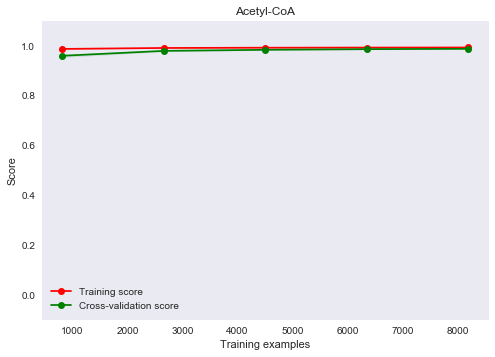

DMAPP


Optimization Progress: 184pipeline [03:30,  1.35s/pipeline]                  

Generation 1 - Current best internal CV score: 1.9848660221498573e-09


Optimization Progress: 272pipeline [06:49,  2.68s/pipeline]                   

Generation 2 - Current best internal CV score: 1.28129314930325e-09


Optimization Progress: 356pipeline [08:49,  1.19s/pipeline]                   

Generation 3 - Current best internal CV score: 1.28129314930325e-09


Optimization Progress: 437pipeline [10:45,  1.17pipeline/s]                   

Generation 4 - Current best internal CV score: 6.627019753227421e-10


Optimization Progress: 531pipeline [13:30,  1.99s/pipeline]                   

Generation 5 - Current best internal CV score: 6.487548361925509e-10


Optimization Progress: 616pipeline [16:18,  1.94s/pipeline]                   

Generation 6 - Current best internal CV score: 6.44363735865172e-10


Optimization Progress: 702pipeline [19:17,  1.45s/pipeline]                   

Generation 7 - Current best internal CV score: 5.740436001879164e-10


Optimization Progress:  99%|█████████▊| 789/800 [23:32<01:03,  5.76s/pipeline]

Generation 8 - Current best internal CV score: 4.22455856193511e-10



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(FastICA(input_matrix, FastICA__tol=0.45), KNeighborsRegressor__n_neighbors=DEFAULT, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=distance)


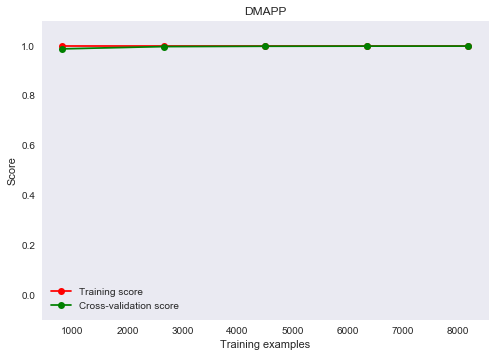

GPP


Optimization Progress: 181pipeline [02:42,  1.19pipeline/s]                  

Generation 1 - Current best internal CV score: 3.9211117704675396e-10


Optimization Progress: 269pipeline [03:35,  4.28pipeline/s]                   

Generation 2 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 357pipeline [04:13,  2.90pipeline/s]                   

Generation 3 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 442pipeline [04:48,  2.50pipeline/s]                   

Generation 4 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 532pipeline [05:57,  1.71pipeline/s]                   

Generation 5 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 620pipeline [07:02,  1.78pipeline/s]                   

Generation 6 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 708pipeline [08:08,  2.52pipeline/s]                   

Generation 7 - Current best internal CV score: 3.480322277381848e-10


Optimization Progress: 802pipeline [09:33,  1.01pipeline/s]0,  1.01pipeline/s]

Generation 8 - Current best internal CV score: 2.915507272482798e-10


Optimization Progress: 100%|█████████▉| 896/900 [10:57<00:05,  1.46s/pipeline]

Generation 9 - Current best internal CV score: 2.2106868705433392e-10


Optimization Progress: 984pipeline [25:43,  3.42s/pipeline]                   

Generation 10 - Current best internal CV score: 2.2106868705433392e-10



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(RobustScaler(input_matrix), KNeighborsRegressor__n_neighbors=2, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=DEFAULT)


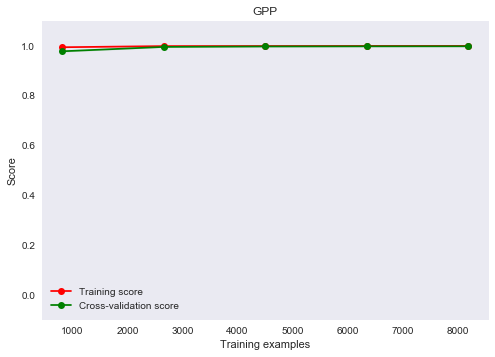

HMG-CoA


Optimization Progress: 183pipeline [03:28,  1.02pipeline/s]                  

Generation 1 - Current best internal CV score: 9.720336521376207e-10


Optimization Progress: 275pipeline [05:03,  1.31s/pipeline]

Generation 2 - Current best internal CV score: 9.588434523570634e-10


Optimization Progress: 366pipeline [06:40,  1.29pipeline/s]                   

Generation 3 - Current best internal CV score: 6.218876103255741e-10


Optimization Progress: 454pipeline [08:00,  1.34pipeline/s]                   

Generation 4 - Current best internal CV score: 6.218876103255741e-10


Optimization Progress: 548pipeline [09:04,  2.23pipeline/s]                   

Generation 5 - Current best internal CV score: 6.218876103255741e-10


Optimization Progress: 633pipeline [09:42,  2.04pipeline/s]                   

Generation 6 - Current best internal CV score: 5.291162860098967e-10


Optimization Progress: 715pipeline [10:35,  1.16pipeline/s]                   

Generation 7 - Current best internal CV score: 5.291162860098967e-10


Optimization Progress: 801pipeline [11:55,  1.21pipeline/s]0,  1.21pipeline/s]

Generation 8 - Current best internal CV score: 5.093524010422902e-10


Optimization Progress:  98%|█████████▊| 884/900 [13:12<00:20,  1.28s/pipeline]

Generation 9 - Current best internal CV score: 5.093524010422902e-10


Optimization Progress: 959pipeline [14:12,  1.17pipeline/s]                   

Generation 10 - Current best internal CV score: 4.834636289278357e-10


Optimization Progress: 1036pipeline [15:10,  1.16pipeline/s]                   

Generation 11 - Current best internal CV score: 3.9693218155530576e-10


Optimization Progress: 1107pipeline [18:06,  1.26s/pipeline]                    

Generation 12 - Current best internal CV score: 3.9693218155530576e-10


Optimization Progress:  99%|█████████▉| 1185/1200 [20:56<00:49,  3.33s/pipeline]

Generation 13 - Current best internal CV score: 3.9693218155530576e-10



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(StandardScaler(input_matrix), KNeighborsRegressor__n_neighbors=2, KNeighborsRegressor__p=1, KNeighborsRegressor__weights=DEFAULT)


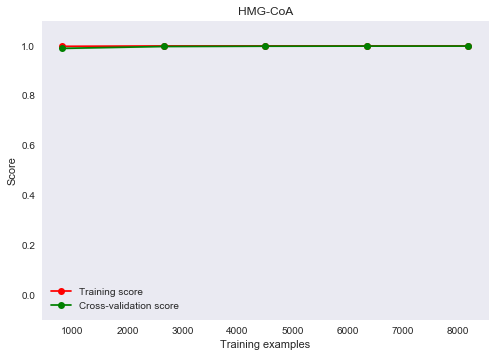

IPP


Optimization Progress: 176pipeline [09:05,  1.56s/pipeline]                  

Generation 1 - Current best internal CV score: 2.0042926855515306e-08


Optimization Progress: 272pipeline [14:07,  6.23s/pipeline]                   

Generation 2 - Current best internal CV score: 2.0042926855515306e-08


Optimization Progress: 370pipeline [6:30:21, 995.42s/pipeline]                

Generation 3 - Current best internal CV score: 2.0042926855515306e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, ElasticNetCV__l1_ratio=0.25, ElasticNetCV__tol=0.1), ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.7, ExtraTreesRegressor__min_samples_leaf=5, ExtraTreesRegressor__min_samples_split=12, ExtraTreesRegressor__n_estimators=100)


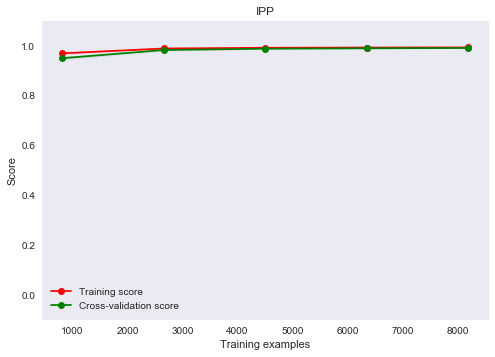

Limonene


Optimization Progress: 181pipeline [05:33,  1.89pipeline/s]                  

Generation 1 - Current best internal CV score: 1.3825225241187413e-09


Optimization Progress: 269pipeline [06:41,  2.02pipeline/s]                   

Generation 2 - Current best internal CV score: 1.3825225241187413e-09


Optimization Progress: 355pipeline [07:59,  1.53pipeline/s]                   

Generation 3 - Current best internal CV score: 1.0604864203106856e-09


Optimization Progress: 434pipeline [09:01,  1.31pipeline/s]                   

Generation 4 - Current best internal CV score: 1.0557425677313633e-09


Optimization Progress: 508pipeline [10:35,  1.34s/pipeline]                   

Generation 5 - Current best internal CV score: 8.460611602173261e-10


Optimization Progress: 100%|█████████▉| 597/600 [12:38<00:04,  1.38s/pipeline]

Generation 6 - Current best internal CV score: 8.023253575758274e-10


Optimization Progress: 687pipeline [15:23,  2.06s/pipeline]                   

Generation 7 - Current best internal CV score: 6.336263782991307e-10


Optimization Progress: 781pipeline [18:51,  2.19s/pipeline]

Generation 8 - Current best internal CV score: 6.336263782991307e-10


Optimization Progress: 875pipeline [22:16,  2.03s/pipeline]                   

Generation 9 - Current best internal CV score: 6.247116073739284e-10



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=DEFAULT, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=10, GradientBoostingRegressor__max_features=0.2, GradientBoostingRegressor__min_samples_leaf=13, GradientBoostingRegressor__min_samples_split=14, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.8)


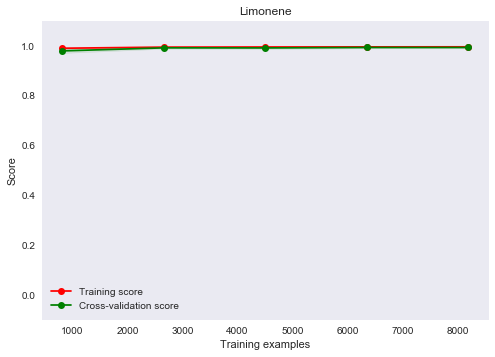

Mev


Optimization Progress: 182pipeline [05:55,  1.61s/pipeline]                  

Generation 1 - Current best internal CV score: 3.7325876018207224e-08


Optimization Progress: 266pipeline [09:07,  3.85s/pipeline]                   

Generation 2 - Current best internal CV score: 3.7325876018207224e-08


Optimization Progress: 363pipeline [12:35,  1.57s/pipeline]                   

Generation 3 - Current best internal CV score: 3.617600817584479e-08


Optimization Progress: 458pipeline [16:59,  2.71s/pipeline]                   

Generation 4 - Current best internal CV score: 3.319668403280538e-08


Optimization Progress: 555pipeline [23:08,  4.19s/pipeline]                   

Generation 5 - Current best internal CV score: 3.319668403280538e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(MinMaxScaler(input_matrix), ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.75, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=9, ExtraTreesRegressor__n_estimators=100)


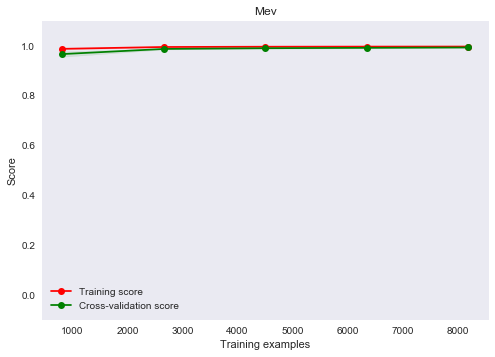

MevP


Optimization Progress: 185pipeline [05:27,  1.88s/pipeline]                  

Generation 1 - Current best internal CV score: 6.195567862306837e-08


Optimization Progress: 274pipeline [09:34,  3.06s/pipeline]

Generation 2 - Current best internal CV score: 6.195567862306837e-08


Optimization Progress: 364pipeline [18:06,  2.16s/pipeline]                   

Generation 3 - Current best internal CV score: 4.803758512940591e-08


Optimization Progress: 459pipeline [23:45,  3.51s/pipeline]                   

Generation 4 - Current best internal CV score: 4.803758512940591e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.8, ExtraTreesRegressor__min_samples_leaf=DEFAULT, ExtraTreesRegressor__min_samples_split=14, ExtraTreesRegressor__n_estimators=100)


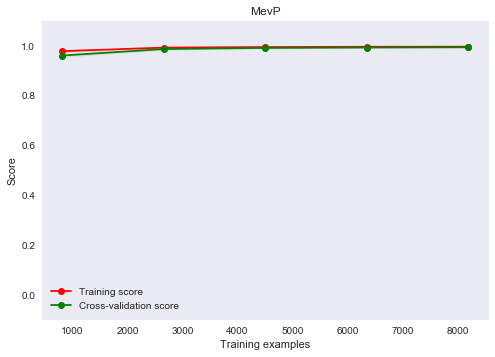

MevPP


Optimization Progress: 169pipeline [04:54,  2.09s/pipeline]                  

Generation 1 - Current best internal CV score: 2.7388062859941293e-08


Optimization Progress: 263pipeline [08:22,  1.54s/pipeline]                   

Generation 2 - Current best internal CV score: 2.6966844988133597e-08


Optimization Progress: 356pipeline [11:52,  2.66s/pipeline]                   

Generation 3 - Current best internal CV score: 2.6966844988133597e-08


Optimization Progress: 450pipeline [16:33,  1.68s/pipeline]                   

Generation 4 - Current best internal CV score: 2.502392392837399e-08


Optimization Progress: 541pipeline [21:38,  3.07s/pipeline]                   

Generation 5 - Current best internal CV score: 2.502392392837399e-08



TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.85, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=4, ExtraTreesRegressor__n_estimators=100)


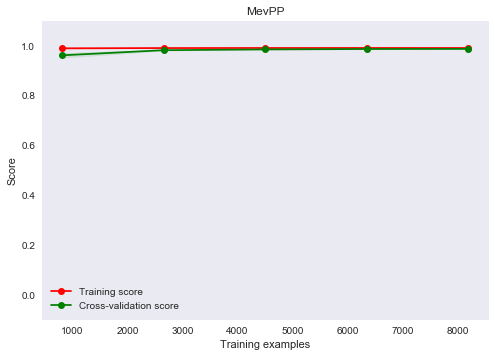

Average Training Score: 0.996187323323 n: 10


In [9]:
#1. Calculate Learning Curves for Derivatives

#Pick number of strains so that the total number is equal to max tested strains...
if data_type == 'simulated':
    strains = tsdf.index.get_level_values(0).unique()
    tsdf_max_strains = tsdf.loc[slice(strains[0],strains[max(strain_numbers)]),slice(None)]
else:
    tsdf_max_strains = tsdf

average_training_score = 0
n = 0
for target_index in tsdf_max_strains.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print(target)


    feature_indecies = [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[feature_indecies].values.tolist()
    y = tsdf_max_strains[target_index].values.tolist()

    #if fit_log_targets:
    #    y = [math.log(val) for val in y]
    
    #print(X)
    #print(y)
    if model_str == 'tpot':
        modelDict[target] = clone(mlmodel).fit(np.array(X),np.array(y)).fitted_pipeline_
        try:
            plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
        except:
            pass
    else:
        modelDict[target] = clone(mlmodel)
        plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
    
    ax = plt.gca()
    ax.set_ylim([-0.1, 1.1])
    plt.show()
    
    modelDict[target] = modelDict[target].fit(X,y)
    average_training_score +=  modelDict[target].score(X,y)
    #print(modelDict[target_name].predict([reduced_features[2]]))
    
average_training_score /= n
print('Average Training Score:',average_training_score,'n:',n)

Total Time Series in Data Set:  200


feature                                               \
                 Acetoacetyl-CoA Acetyl-CoA          AtoB     DMAPP       GPP   
Strain Time (h)                                                                 
31     0.000000         0.199866   0.200161  3.660104e+05  0.199978  0.200036   
       0.696970         0.201791   0.202891  2.085323e+06  0.200553  0.199436   
       1.393939         0.203961   0.205300  3.369448e+06  0.201171  0.198790   
       2.090909         0.206376   0.207387  4.218385e+06  0.201830  0.198100   
       2.787879         0.209143   0.209020  4.356961e+06  0.202548  0.197335   
       3.484848         0.212028   0.210485  4.390275e+06  0.203288  0.196559   
       4.181818         0.214966   0.211866  4.452292e+06  0.204041  0.195786   
       4.878788         0.217947   0.213181  4.505450e+06  0.204809  0.195015   
       5.575758         0.220967   0.214436  4.545609e+06  0.205590  0.194247   
       6.272727         0.224024   0.215635  4.576766e+06  0.206387  0.193483   
       6.969697         0.227111   0.216789  4.602369e+06  0.207198  0.192723   
       7.666667         0.230221   0.217905  4.623793e+06  0.208020  0.191969   
       8.363636         0.233356   0.218983  4.641506e+06  0.208856  0.191219   
       9.060606         0.236513   0.220026  4.656532e+06  0.209705  0.190476   
       9.757576         0.239687   0.221042  4.669721e+06  0.210564  0.189738   
       10.454545        0.242880   0.222029  4.681108e+06  0.211435  0.189005   
       11.151515        0.246091   0.222987  4.691045e+06  0.212318  0.188279   
       11.848485        0.249317   0.223922  4.699940e+06  0.213210  0.187559   
       12.545455        0.252556   0.224834  4.707872e+06  0.214113  0.186844   
       13.242424        0.255811   0.225722  4.714943e+06  0.215026  0.186135   
       13.939394        0.259079   0.226588  4.721340e+06  0.215949  0.185433   
       14.636364        0.262359   0.227435  4.727172e+06  0.216880  0.184736   
       15.333333        0.265652   0.228261  4.732455e+06  0.217821  0.184045   
       16.030303        0.268956   0.229068  4.737277e+06  0.218771  0.183360   
       16.727273        0.272271   0.229857  4.741736e+06  0.219728  0.182681   
       17.424242        0.275597   0.230629  4.745830e+06  0.220694  0.182008   
       18.121212        0.278934   0.231382  4.749600e+06  0.221668  0.181341   
       18.818182        0.282280   0.232119  4.753118e+06  0.222650  0.180679   
       19.515152        0.285635   0.232841  4.756388e+06  0.223638  0.180023   
       20.212121        0.289000   0.233546  4.759425e+06  0.224634  0.179373   
...                          ...        ...           ...       ...       ...   
9992   48.787879        0.472012   0.143373  8.366196e+06  0.224550  0.162638   
       49.484848        0.475427   0.143025  8.367269e+06  0.224959  0.162219   
       50.181818        0.478833   0.142687  8.368311e+06  0.225368  0.161803   
       50.878788        0.482231   0.142358  8.369325e+06  0.225778  0.161390   
       51.575758        0.485622   0.142038  8.370313e+06  0.226188  0.160980   
       52.272727        0.489005   0.141727  8.371274e+06  0.226599  0.160573   
       52.969697        0.492380   0.141424  8.372209e+06  0.227010  0.160168   
       53.666667        0.495748   0.141129  8.373122e+06  0.227421  0.159766   
       54.363636        0.499110   0.140843  8.374011e+06  0.227833  0.159368   
       55.060606        0.502464   0.140565  8.374876e+06  0.228245  0.158972   
       55.757576        0.505811   0.140294  8.375722e+06  0.228658  0.158578   
       56.454545        0.509153   0.140030  8.376546e+06  0.229070  0.158188   
       57.151515        0.512487   0.139774  8.377350e+06  0.229483  0.157800   
       57.848485        0.515816   0.139525  8.378135e+06  0.229896  0.157415   
       58.545455        0.519139   0.139282  8.378902e+06  0.230309  0.157033   
       59.242424        0.522455   0.139046  8.379650e+0

Acetoacetyl-CoA Mean Error: 2.12418361238e-06 Error Standard Deviation: 0.000268856780864


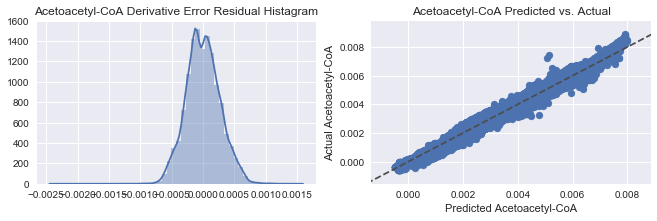

Acetyl-CoA Mean Error: 0.000109151499965 Error Standard Deviation: 0.000472419644352


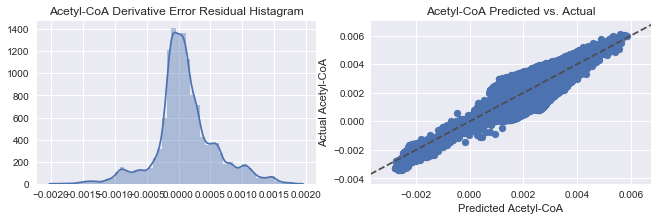

DMAPP Mean Error: -2.56819097948e-06 Error Standard Deviation: 0.00016854502635


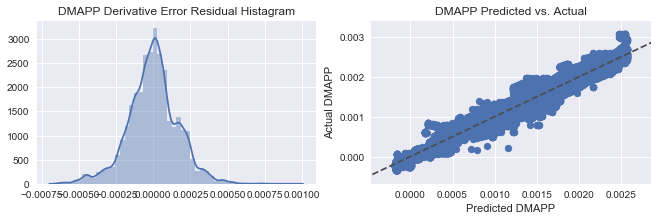

GPP Mean Error: -1.4757214357e-05 Error Standard Deviation: 0.000119405717209


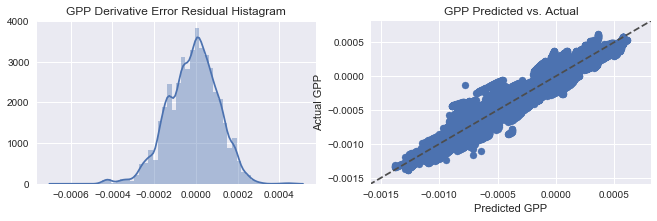

HMG-CoA Mean Error: 4.96763779416e-08 Error Standard Deviation: 0.0001415783036


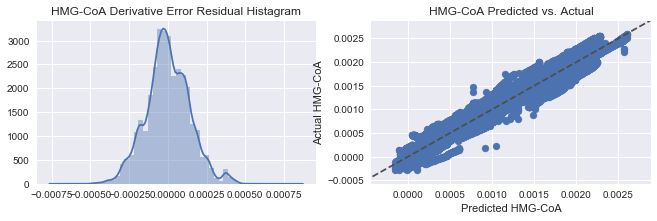

IPP Mean Error: 4.35459987478e-05 Error Standard Deviation: 0.00038300271612


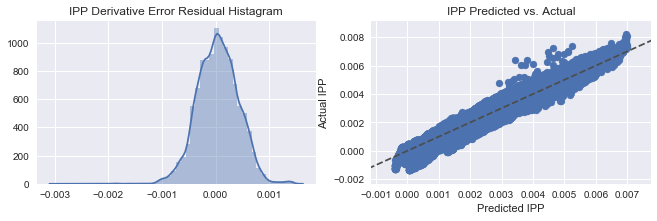

Limonene Mean Error: 3.82748780275e-06 Error Standard Deviation: 4.43722214356e-05


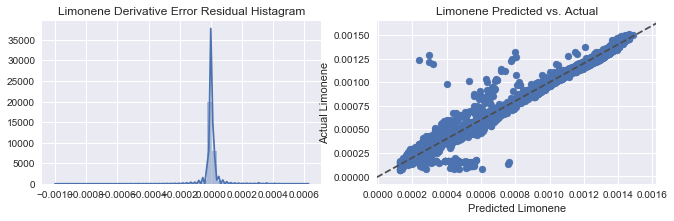

Mev Mean Error: -7.6689203069e-05 Error Standard Deviation: 0.000286857435656


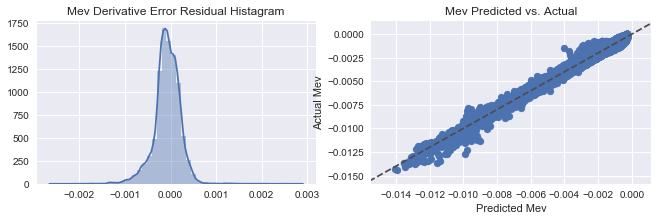

MevP Mean Error: 8.1781154808e-05 Error Standard Deviation: 0.000275063282059


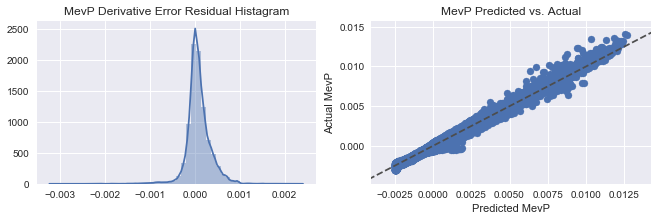

MevPP Mean Error: -3.75541987984e-05 Error Standard Deviation: 0.000295393933131


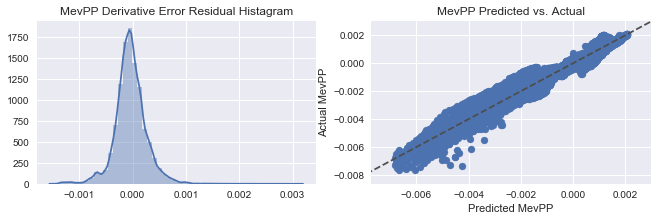

Total Derivative Mean Error: 0.000797188871309 Error Standard Deviation: 0.000380212908476


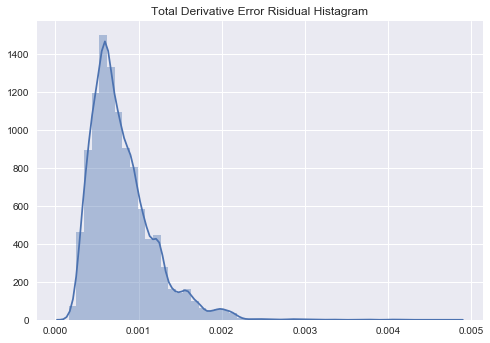

In [10]:
#2. Calculate Error Distribution and Plot + Report Moments
ts_test_df = generateTSDataSet(test_df,features,targets)
display(ts_test_df)
errors = []
for target in modelDict:
    times,y_test = remove_NaN(ts_test_df.reset_index()['Time (h)'].values,ts_test_df[('target',target)].values)
    
    feature_list = [('feature',feature) for feature in specific_features[target]]
    target_df = ts_test_df[feature_list]
    target_df = target_df[ts_test_df.index.get_level_values('Time (h)').isin(times)]
    
    #Check to make sure there are no NaNs in each feature
    for feature in target_df.columns:
        if any([math.isnan(val) for val in target_df[feature].values]):
            X,y = remove_NaN(target_df.reset_index()['Time'].values,target_df[feature].values)
            fnc = interp1d(X,y)
        index = 0
        for time,val in zip(times,target_df[feature].values):
            if math.isnan(val):
                #print(feature,time,fnc(time))
                target_df[feature].iloc[index] = fnc(time)
            index += 1
    #display(target_df)
    
    y_prediction = modelDict[target].predict(target_df.values)
    
    #print(y_prediction)
    #print(y_test)
    log_error = [math.log(max(y_p,0.0001)) - math.log(max(y_t,0.0001)) for y_p,y_t in zip(y_prediction,y_test)]
    error = [y_p - y_t for y_p,y_t in zip(y_prediction,y_test)]
    errors.append(error)
    
    mu = np.mean(error)
    sigma = np.std(error)
    print(target,'Mean Error:',mu,'Error Standard Deviation:',sigma)
    
    plt.figure(figsize=(11,3))
    plt.subplot(121)
    sns.distplot(error)
    plt.title(target + ' Derivative '+ 'Error Residual Histagram')
    
    plt.subplot(122)
    plot_model_fit(target,y_prediction,y_test)
    plt.show()
    
    #modelDict[target].predict()

#Compute Net Error Magnitude
error_magnitude = [0]*len(errors[0])
for error in errors:
    error_magnitude = [em + e**2 for em,e in zip(error_magnitude,error)]
error_magnitude = [math.sqrt(e) for e in error_magnitude]
mu = np.mean(error_magnitude)
sigma = np.std(error_magnitude)
print('Total Derivative','Mean Error:',mu,'Error Standard Deviation:',sigma)
    
sns.distplot(error_magnitude)
plt.title('Total Derivative Error Risidual Histagram')
plt.show()

In [11]:
# If Experimental Limonene Results show that the Hand created 
# Kinetic Model Does not fit as well as the machine learning model

def proteomicsData(t,k):
    e = []
    for i in range(int(len(k)/3)):
        #Sorting the gains to ensure proteins only increase
        gains = sorted(k[3*i:3*(i+1)],reverse=True)
        e.append(leaky_hill_fcn(t,*gains)) 
    return e


def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
def solve_kinetic_ode(f,y0,times,k_fit):
    sol = 1
    return sol

measured_substrates = ['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Limonene g/L']
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
x_features = [('feature',val) for val in measured_enzymes+measured_substrates]
y_targets = [('target',val) for val in measured_substrates]

#print(x_features)
#print(y_targets)

if data_type == 'experimental' and  pathway == 'limonene':
    [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[x_features].values.tolist()
    y = tsdf_max_strains[y_targets].values.tolist()
    
    #Solve for Kinetic Coefficients from Training Set
    def cost_fcn_gen(X,y):
        def cost_fcn(free_params):
            cost = 0
            for x_val,y_vals in zip(X,y):
                params = []
                params.extend(x_val[0:6])       # AtoB to PMD Values
                params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
                params.extend(x_val[6:8])       # LS and Acetyl-CoA
                params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
                params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
                params.append(free_params[3])   #MevPP 
                params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
                params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
                params.extend(free_params[5:])  # Remaining Kinetic Free Parameters
                
                mp = kinetic_model(*params)
                prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
                cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
            return cost
        return cost_fcn

    cost_fcn = cost_fcn_gen(X,y)
    
    #Call to check its working (num free params = 39)
    print(cost_fcn([1,]*39))
    
    #Solve For Optimal Parameters
    bounds = [(1*10**-12,10**9)]*39
    sol = differential_evolution(cost_fcn,bounds,disp=True,maxiter=10000)
    best_params = sol.x
    print(best_params)

In [12]:
import statistics

def plot_species_curves(modelDict, title, df, targets, specific_features, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3),training_sets=5):
    """
    Generate a simple plot of the test and training learning curve. Returns Metrics for each predicted curve

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    #Set Random Seed For training
    seed = 103
    random.seed(seed)
    
    #Create figure / plots
    fig = plt.figure(figsize=(12,16))
    #fig.set_title(title)
    #if ylim is not None:
    #    plt.ylim(*ylim)
    
    #Create subplots for each target
    ax = {}
    for i,target in enumerate(targets):
        ax[target] = plt.subplot(int(len(targets)/2)+1, 2, i+1)
    
    #Get Randomized List of all Strains
    strains = df.index.get_level_values(0).unique()
    strains = list(strains.values)
    #print(strains)
    strains = random.sample(strains, len(strains))
    
    #Pick test strain
    test_df = df.loc[(slice(strains[0],strains[0]),slice(None)),:]
    strains = strains[1:]
    
    #Create Interpolation functions for each feature in the test strain
    interpFun = {}
    #display(test_df.reset_index())
    for feature in df.columns:
        X,y = remove_NaN(test_df.reset_index()['Time (h)'].tolist(),test_df[feature].tolist())
        if isinstance(feature,tuple):
            if feature[0] == 'feature':
                feature = feature[1]
            else:
                continue

        interpFun[feature] = interp1d(X,y)  

    train_sizes = [int(len(strains)*size/training_sets)-1 for size in train_sizes]
    for i,size in enumerate(train_sizes):
        if size < 2:
            train_sizes[i] = 2
            
    #Create Fits for each training set
    fits = {}
    for training_set in range(training_sets):        
        fits[training_set] = {}

        #Generate training strain data for this training set
        training_strains = strains[0:(train_sizes[-1] + 1)]
        #print(training_strains)
        strains = strains[train_sizes[-1]:]
        endSamples = train_sizes
        #print('Strains:',strains)
        #print('End Samples',endSamples)
        sample_sets = [df.loc[(training_strains[0:endSample],slice(None)),:] for endSample in endSamples]

        #For each set size in the training set fit the model and store it
        for j,sample_set in enumerate(sample_sets):
            
            #print('Sample Set:',sample_set.index.get_level_values(0).unique().values)
            
            # Train Model
            print('Training Models for Training Set',training_set,'In Sample set',j)
            for target in targets:
                feature_indecies = [('feature', feature) for feature in specific_features[target]]
                X = sample_set[feature_indecies].values.tolist()

                #print(feature_indecies)
                #display(sample_set[feature_indecies])
                target_index = ('target',target)
                y = sample_set[target_index].values.tolist()
                modelDict[target].fit(X,y)

            print('Integrating ODEs!')
            # Integrate Given Model Test Case
            g = mlode(modelDict, test_df, targets, specific_features)
            times = test_df.reset_index()['Time (h)'].tolist()

            #Set Y0 initial condition
            appended_targets = [('feature',target) for target in targets]
            #display(test_df)
            #display(test_df[appended_targets].iloc[0])
            y0 = test_df[appended_targets].iloc[0].tolist()

            #print('times:',times)
            fit  = odeintz(g,y0,times)
            fitT = list(map(list, zip(*fit)))
            fits[training_set][train_sizes[j]] = fitT

    
    #Perform Statistics on Fits and generate plots
    colors = ['b','g','k','y','m']
    predictions = {}
    lines =[]
    labels = []
    for k,target in enumerate(targets):
        actual_data = [interpFun[target](t) for t in times]
        predictions[target] = {'actual':actual_data}
        predictions['Time'] = times
        if k == 0:
            lines.append(ax[target].plot(times,actual_data,'--', color='r')[0])
            labels.append('Actual Dynamics')
        else:
            ax[target].plot(times,actual_data,'--', color='r')
        ax[target].set_title(target)
        
        for j in range(len(sample_sets)):
            upper = []
            lower = []
            aves = []
            
            predictions[target][train_sizes[j]] = []
            for training_set in range(training_sets):
                predictions[target][train_sizes[j]].append(fits[training_set][train_sizes[j]][k])
            
            for i,time in enumerate(times):
                
                values = []
                for training_set in range(training_sets):
                    #print(training_set,train_sizes[j],i)
                    values.append(fits[training_set][train_sizes[j]][k][i])

                #Compute Statistics of Values
                #print(values)
                ave = statistics.mean(values)
                std = statistics.stdev(values)
                aves += [ave,]
                upper += [ave + std,]
                lower += [ave - std,]
                
                #print(upper)
                #print(times)
                
            #Compute upper and lower bounds for shading
            ax[target].fill_between(times, lower,upper, alpha=0.1, color=colors[j])
            if k == 0:
                lines.append(ax[target].plot(times,aves,colors[j])[0])
                labels.append(str(train_sizes[j]) + ' Strain Prediction')
            else:
                ax[target].plot(times,aves,colors[j])
            print(colors[j],train_sizes[j])
        plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )       

    return predictions

Training Models for Training Set 0 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 0 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 0 In Sample set 2
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 0
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 1
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP', 'IPP', 'DMAPP', 'GPP', 'Limonene']
Training Models for Training Set 1 In Sample set 2
Integrating ODEs!
['Acetyl-CoA', 'Acetoacetyl-CoA', 'HMG-CoA', 'Mev', 'MevP', 'MevPP

FileNotFoundError: [Errno 2] No such file or directory: 'data/theFig.eps'

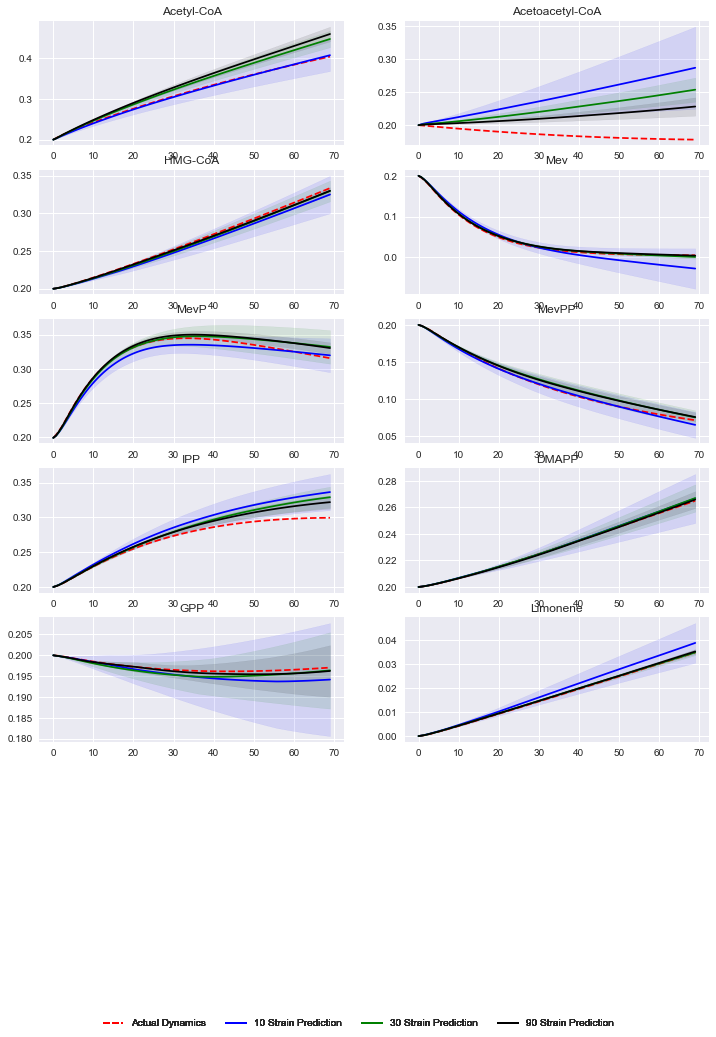

In [13]:
#3. Plot Comparison between Actual and Predicted Results
if data_type == 'simulated':
    real_vs_predicted = plot_species_curves(modelDict, 'title', tsdf, targets, specific_features,train_sizes=train_sizes,training_sets=training_sets)
    plt.savefig('data/theFig.eps', format='eps', dpi=600)
    
    
elif data_type == 'experimental':
    #Fit each test strain by solving the differential equation

    #Select Random Time Series
    #test_df = df
    #display(test_df)
    strains = test_df.index.get_level_values(0).unique()
    #print(strains)

    random_strain = random.sample(tuple(strains), 1)
    #print(random_strain)

    random_strain = list(random_strain)[0]
    #random_strain = 180
    random_df = test_df.loc[(slice(random_strain,random_strain),slice(None)),:]
    #print('The Chosen Random Strain is:', random_strain)

    #Set Y0 initial condition
    y0 = random_df[targets].iloc[0].tolist()
    print('y0',y0)
    
    #Create Differential Equation to Solve
    #print('Creating Differential Equation!')
    if featureReduction:
        target_features = [header[1:]]*len(targets[0])
        g = mlode(modelDict, random_df, targets, specific_features)
    else:
        g = mlode(modelDict, random_df, targets, specific_features,time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    #print('Solving Differential Equation')
    times = random_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    
    #Create Interpolation functions for each feature
    interpFun = {}
    for feature in random_df.columns:
        X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
        interpFun[feature] = interp1d(X,y)

        
    if pathway == 'limonene':
        #print(random_df.columns)
        proteins = ['AtoB', 'HMGR', 'HMGS', 'MK', 'PMD', 'PMK','Limonene Synthase']
        protein_fcns= []
        for feature in random_df.columns:
            X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
            protein_fcns.append(interp1d(X,y))
        
        #Generate Fit Kinetic Model ODE
        def kinetic_ode(x,t,proteomic_fcns):
            
            #proteomics 
            proteomic_data = [proteomic_fcn(t) for proteomic_fcn in proteomic_fcns]

            params = []
            params.extend(proteomic_data[0:6]) # AtoB to PMD Values
            params.extend(best_params[0:2])     # Keep Constant GPPS and IDI levels as free parameters
            params.append(proteomic_data[6])   # 
            params.append(x[0])                #Acetyl-CoA
            params.append(best_params[2])       # AcetoAcetyl-CoA as a free Param
            params.extend(x[1:4])               # HMG-CoA & Mev & MevP measured
            params.append(best_params[3])       # MevPP 
            params.extend([x[4],x[4]])          # DMAPP & IDI Measured
            params.extend([best_params[4],x[5]]) # GPP as a Free Parameter #Measured Limonene Synthase
            params.extend(best_params[5:])      # Remaining Kinetic Free Parameters
            
            
            dxdt = kinetic_model(*params)
            dxdt_combined = [dxdt[0],dxdt[2],dxdt[3],dxdt[4],dxdt[6]+dxdt[7],dxdt[9]]
            return dxdt_combined
        
        for protein in proteins:
            protein_fcns.append(interpFun[protein])
        
        #Solve Kinetic ODE at initial Conditions
        kinetic_ode_p = lambda x,t : kinetic_ode(x,t,protein_fcns)
        kinetic_fit = odeintz(kinetic_ode_p,y0,times)
        kinetic_fit = list(map(list, zip(*kinetic_fit)))
        
    real_vs_predicted = {}
    plt.figure(figsize=(12,8))
    for i,target in enumerate(targets):
        plt.subplot(2,3,i+1)
        if data_type == 'experimental':
            #Plot both High and Low Strain values
            for strain in training_strains:
                strainInterpFun = {}
                strain_df = df.loc[(strain,slice(None))]
                X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
                strainInterpFun[target] = interp1d(X,y)
                actual_data = [strainInterpFun[target](t) for t in times]
                train_line, = plt.plot(times,actual_data,'r--')
            
            #Plot Kinetic Model Fit
            if pathway =='limonene':
                kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times)]
                kinetic_line, = plt.plot(times,kinetic_pred,color='k')

        actual_data = [interpFun[target](t) for t in times]
        pos_pred = [max(fitT[i][j],0) for j,t in enumerate(times)]
        prediction_line, = plt.plot(times,pos_pred)
        #print(actual_data)
        test_line, = plt.plot(times,actual_data,'--')
        plt.ylabel(target)
        plt.xlabel('Time [h]')
        plt.xlim([0,72])
        
        if i == 5 and pathway == 'limonene':
            plt.ylim([0,0.6])
        
        #Create variable for processing error residuals
        if pathway == 'limonene':
            real_vs_predicted[target] = [times,actual_data,pos_pred,kinetic_pred]
        else:
            real_vs_predicted[target] = [times,actual_data,pos_pred]
    #Add Legend
    if set_num==2:
        product = 'Isopentenol'
    elif set_num==3:
        product = 'Limonene'
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.subplots_adjust(bottom=0.12)
    plt.suptitle('Prediction of ' + product + ' Strain Dynamics', fontsize=18)
    if pathway == 'limonene':
        plt.figlegend( (train_line,test_line,prediction_line,kinetic_line), ('Training Set Data','Test Data','Machine Learning Model Prediction','Kinetic Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. )  
    else:
        plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
    plt.savefig('data/' + product + '_prediction.eps', format='eps', dpi=600)
    plt.show()

In [14]:
#4. Error Residuals of Time Series Data + Key Moments Report

#Not Quite Right... Need to Integrate over the 
if data_type == 'experimental':
    #print(real_vs_predicted)

    rmse_percent = []
    rmse_average = []
    rmse_percent_k = []
    rmse_average_k = []
    for metabolite in real_vs_predicted:
        if pathway == 'limonene':
            times,real,predicted,kinetic = real_vs_predicted[metabolite]
        else:
            times,real,predicted = real_vs_predicted[metabolite]
        real_fcn = interp1d(times,real)
        pred_fcn = interp1d(times,predicted)

        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
        rmse = math.sqrt(quad(integrand,min(times),max(times))[0])
        rmse_average.append(rmse)
        percent_integrand = lambda t: abs(real_fcn(t) - pred_fcn(t))/(real_fcn(t)*max(times))
        #print(metabolite,[percent_integrand(t) for t in times],[real_fcn(t) for t in times],[pred_fcn(t) for t in times])
        
        rmsep = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
        rmse_percent.append(rmsep)
        print('ML Fit:',metabolite,rmse,'RMSE percent:',rmsep*100)
        
        if pathway == 'limonene':
            kinetic_fcn = interp1d(times,kinetic)
            integrand = lambda t: (real_fcn(t) - kinetic_fcn(t))**2
            rmsek = math.sqrt(quad(integrand,min(times),max(times))[0])
            percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
            rmsepk = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
            rmse_percent_k.append(rmsepk)
            rmse_average_k.append(rmsek)
            print('Kinetic Fit:',metabolite,rmsek,'RMSE percent:',rmsepk*100)
    
    print('')
    print('Machine Learning Model Agrigate Error')
    print('Average RMSE:',sum(rmse_average)/len(rmse_average))
    print('Total Percent Error:',sum(rmse_percent)/len(rmse_percent)*100)

    if pathway == 'limonene':
        print('')
        print('Kinetic Model Agrigate Error')
        print('Average RMSE:',sum(rmse_average_k)/len(rmse_average_k))
        print('Total Percent Error:',sum(rmse_percent_k)/len(rmse_percent_k)*100)
        
elif data_type == 'simulated':
    times = real_vs_predicted['Time']
    rmse_dict = {}
    for metabolite in real_vs_predicted:
        if metabolite not in ['Time',]:
            actual = real_vs_predicted[metabolite]['actual']
            real_fcn = interp1d(times,actual)
            rmse_dict[metabolite] = {}
            for test_size in real_vs_predicted[metabolite]:
                print(metabolite,'Test Size:',test_size)
                total_rmse = []
                if test_size not in ['Time','actual']:
                    #For Each Test Size Produce Values + Moments Reporting...
                    rmse = []
                    for test_strain in enumerate(real_vs_predicted[metabolite][test_size]):
                        #print(test_strain)
                        pred_fcn = interp1d(times,test_strain[1])
                        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
                        rmse.append(math.sqrt(quad(integrand,min(times),max(times))[0]))
                        
                    #Report Moments for each Test Size
                    rmse_dict[metabolite][test_size] = rmse
                    print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
                    print('RMSEs:',rmse)
                    print('')
                    

    #Calculate Mean Total Error + Mean Standard Deviation for Composite Error
    size_dict = {}
    for metabolite in rmse_dict:
        for test_size in rmse_dict[metabolite]:
            size_dict[test_size] = [0]*len(rmse_dict[metabolite][test_size])
            size_dict[test_size] = [s + r for s,r in zip(rmse_dict[metabolite][test_size],size_dict[test_size])]

    #Print out Agrigate Statistics
    for test_size in size_dict:
        rmse = size_dict[test_size]
        print('Test Size for Agrigate Statistics:',test_size)
        print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
        print('RMSEs:',rmse)
        print('')

Acetyl-CoA Test Size: actual
Acetyl-CoA Test Size: 10


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Mean RMSE: 0.134320144936 Standard Deviation RMSE: 0.120994297649
RMSEs: [0.03584353151268605, 0.2764851611623937, 0.18784532175334, 0.10510501251189847, 0.04329767939573539, 0.041688513886116614, 0.39929339434322536, 0.016415219751832615, 0.19377269332780395, 0.043454921712432655]

Acetyl-CoA Test Size: 30
Mean RMSE: 0.19169515326 Standard Deviation RMSE: 0.0894669381132
RMSEs: [0.04441327017098068, 0.27031478021401417, 0.26610425147598293, 0.24722476920661143, 0.324036458403576, 0.14310555685345663, 0.21976790231350404, 0.22550285549065732, 0.10124625028771904, 0.0752354381829095]

Acetyl-CoA Test Size: 90
Mean RMSE: 0.249255857237 Standard Deviation RMSE: 0.0786809434879
RMSEs: [0.20622853271092928, 0.32141014208057206, 0.36879337934772505, 0.19028278401012116, 0.22426780272567282, 0.1536502781859737, 0.23491169745011087, 0.13551484726054683, 0.35646396406147424, 0.30103514453245467]

Acetoacetyl-CoA Test Size: actual
Acetoacetyl-CoA Test Size: 10
Mean RMSE: 0.54615909092 Standard D

Mean RMSE: 0.0216217735565 Standard Deviation RMSE: 0.00933065885102
RMSEs: [0.010988353678655813, 0.009983105360047843, 0.021749788564801115, 0.024570427787190305, 0.029749207508399954, 0.01828424191505554, 0.04070959417243759, 0.022159935755977855, 0.02789740930443669, 0.010125671517925356]

Limonene Test Size: actual
Limonene Test Size: 10
Mean RMSE: 0.0294327982265 Standard Deviation RMSE: 0.0273722284213
RMSEs: [0.006374977160218735, 0.04126526548269055, 0.023811679998391972, 0.0009409236161229041, 0.0911848103527827, 0.0038253520518851383, 0.049208006408745356, 0.023097632103292392, 0.05041890538860444, 0.004200429702441957]

Limonene Test Size: 30
Mean RMSE: 0.00473123964183 Standard Deviation RMSE: 0.00255159543666
RMSEs: [0.0017405320279400064, 0.0051669465974077625, 0.0058079393475573005, 0.0012273581029536695, 0.008189757746162665, 0.007028815377016406, 0.003625073858354505, 0.008740122782186412, 0.003680962159901797, 0.0021048884187970453]

Limonene Test Size: 90
Mean RMSE:

In [ ]:
print(best_params)